In [3]:
!pip install scikit-learn==0.24.1  aif360==0.3.0  tensorflow==2.4.0 lime==0.2.0.1 nodejs==0.1.1 ipywidgets==7.6.3 #aix360==0.2.1

You should consider upgrading via the '/opt/conda/bin/python -m pip install --upgrade pip' command.


In [ ]:
!jupyter labextension install @jupyter-widgets/jupyterlab-manager

In [1]:
import tensorflow as tf
from tensorflow import keras

In [2]:
model = keras.models.load_model('model')

In [3]:
batch_size = 1
img_height = 244
img_width = 244
input_shape = (img_width,img_height)
num_classes=2

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  'data',
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  'data',
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

train_ds = train_ds.map(lambda x, y: (x, tf.one_hot(y, depth=num_classes)))
val_ds = val_ds.map(lambda x, y: (x, tf.one_hot(y, depth=num_classes)))


Found 1410 files belonging to 2 classes.
Using 1128 files for training.
Found 1410 files belonging to 2 classes.
Using 282 files for validation.


In [4]:
predicted_classes = model.predict(val_ds, batch_size=batch_size)

In [5]:
import numpy as np
y_test = None
for features, labels in val_ds:
    if y_test is not None:
        y_test = np.vstack((y_test,labels.numpy()))
    else:
        y_test = labels.numpy()


In [6]:
from lime import lime_image
explainer = lime_image.LimeImageExplainer()

In [7]:
# get an image
for image, label in val_ds:
    break
image = image.numpy()
image = image.reshape(244,244,3)

In [8]:
from lime.wrappers.scikit_image import SegmentationAlgorithm
segmentation_fn = SegmentationAlgorithm(algo_type = 'slic')

In [9]:
explanation = explainer.explain_instance(image, model.predict, segmentation_fn=segmentation_fn)


/opt/conda/lib/python3.8/site-packages/lime/wrappers/scikit_image.py:117: FutureWarning: skimage.measure.label's indexing starts from 0. In future version it will start from 1. To disable this warning, explicitely set the `start_label` parameter to 1.
  return self.target_fn(args[0], **self.target_params)


In [14]:
image, mask = explanation.get_image_and_mask(1)

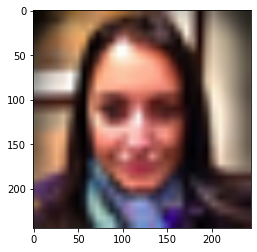

In [15]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
imgplot = plt.imshow(image.astype(int))

In [18]:
import numpy as np
np_image = np.array(image.astype(int))
np_mask = np.array(mask.astype(int)*255,np.uint8)
np_merged = np.empty(np_image.shape, np.uint8)
np_merged[:,:,0] = np.maximum(np_image[:,:,0],np_mask)
np_merged[:,:,1] = np.maximum(np_image[:,:,1],np_mask)
np_merged[:,:,2] = np.maximum(np_image[:,:,2],np_mask)

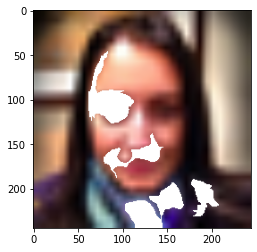

In [19]:
plt.imshow(np_merged)